# E-Commerce Transactions Project  

This project uses historical transaction data from a UK-based online retailer (Dec 2010–Dec 2011). The company primarily sells unique gift items, and many of its customers are wholesalers.  

The purpose of this project is to analyze this dataset to generate actionable insights that can guide business decision-making. By examining customer behavior, product performance, and sales trends, our team aims to support inventory optimization, targeted marketing, and overall revenue growth.  

**Team Members:**  
- Austin Mallie  
- Francisco Hernandez  
- Niat Kahsay  


# EDA

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import missingno as msno
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [10]:
#Load data
df = pd.read_csv('data.csv', encoding='latin1')

In [11]:
#initial data exploration 

print("Dataset Shape:", df.shape)
display(df.head())

Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [12]:
# Data types
display(df.dtypes)

#dataset statistics 
display(df.describe(include='all').T)

# Missing values
print("\nMissing Values by Column:")
display(df.isnull().sum())


InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
InvoiceNo,541909,25900,573585,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,541909,4070,85123A,2313,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,541909.0,NaN,NaN,NaN,9.55225,218.081158,-80995.0,1.0,3.0,10.0,80995.0
InvoiceDate,541909,23260,10/31/2011 14:41,1114,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UnitPrice,541909.0,NaN,NaN,NaN,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,NaN,NaN,NaN,15287.69057,1713.600303,12346.0,13953.0,15152.0,16791.0,18287.0
Country,541909,38,United Kingdom,495478,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing Values by Column:


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [13]:
missing_count = df.isnull().sum()
missing_percentage = (missing_count / len(df) * 100).round(1)
missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_count.values,
    'Missing_Percentage': missing_percentage.values
})

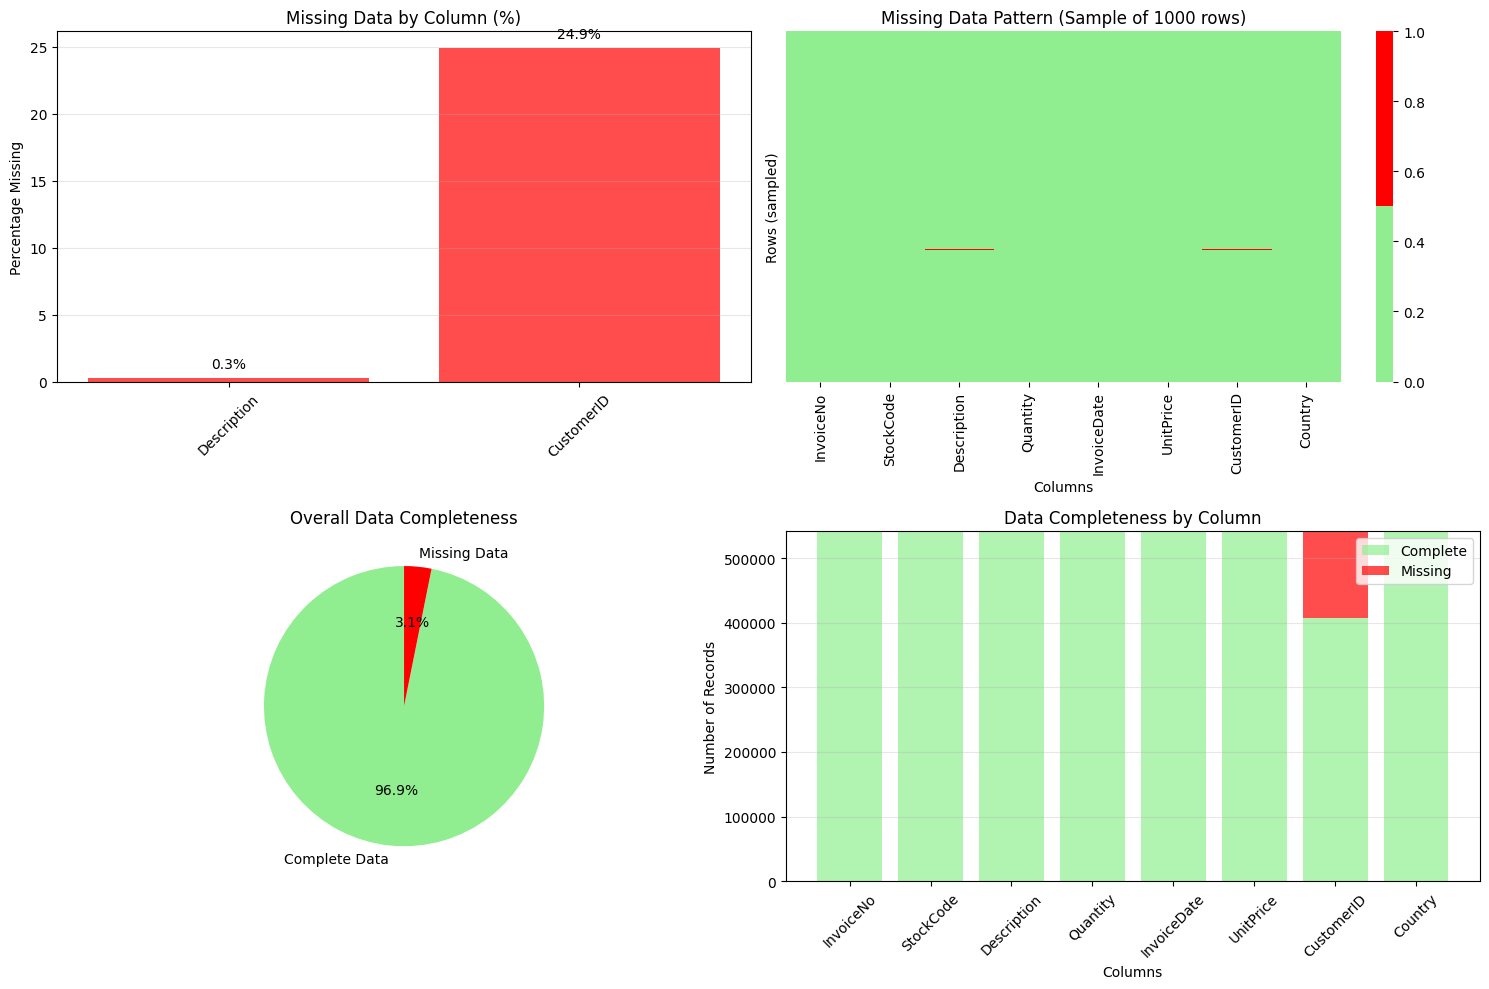

In [14]:
# missing data visualization 
plt.figure(figsize=(15, 10))

# Bar chart of missing values by column
plt.subplot(2, 2, 1)
missing_plot_data = missing_summary[missing_summary['Missing_Count'] > 0]
plt.bar(missing_plot_data['Column'], missing_plot_data['Missing_Percentage'], color='red', alpha=0.7)
plt.title('Missing Data by Column (%)')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
for i, v in enumerate(missing_plot_data['Missing_Percentage']):
    plt.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# Heatmap of missing values (sampled)
plt.subplot(2, 2, 2)
sample_size = min(1000, len(df))
sns.heatmap(df.isnull().iloc[:sample_size, :], cbar=True, yticklabels=False, cmap=['lightgreen', 'red'])
plt.title('Missing Data Pattern (Sample of 1000 rows)')
plt.xlabel('Columns')
plt.ylabel('Rows (sampled)')

# Overall data completeness pie chart
plt.subplot(2, 2, 3)
total_missing = missing_count.sum()
total_cells = df.shape[0] * df.shape[1]
completeness = [total_cells - total_missing, total_missing]
labels = ['Complete Data', 'Missing Data']
colors = ['lightgreen', 'red']
plt.pie(completeness, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Overall Data Completeness')

# Stacked bar chart by column
plt.subplot(2, 2, 4)
complete_data = [len(df) - missing_count[col] for col in df.columns]
missing_data = missing_count.values
x_pos = range(len(df.columns))
plt.bar(x_pos, complete_data, color='lightgreen', label='Complete', alpha=0.7)
plt.bar(x_pos, missing_data, bottom=complete_data, color='red', label='Missing', alpha=0.7)
plt.title('Data Completeness by Column')
plt.xlabel('Columns')
plt.ylabel('Number of Records')
plt.xticks(x_pos, df.columns, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
# comprehensive data quality report
def data_quality_report(df):
    print("DATA QUALITY ASSESSMENT")
    print(f"Dataset Dimensions: {df.shape[0]} rows, {df.shape[1]} columns")
    print("\n  Missing Values Analysis:")
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    missing_report = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing %': missing_percent
    })
    print(missing_report[missing_report['Missing Count'] > 0])
    
    print("\n Data Types Overview:")
    print(df.dtypes)
    
    print("\n Duplicate Records Check:")
    duplicates = df.duplicated().sum()
    print(f"Total duplicate rows: {duplicates} ({duplicates/len(df)*100:.2f}%)")

data_quality_report(df)

DATA QUALITY ASSESSMENT
Dataset Dimensions: 541909 rows, 8 columns

  Missing Values Analysis:
             Missing Count  Missing %
Description           1454   0.268311
CustomerID          135080  24.926694

 Data Types Overview:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

 Duplicate Records Check:
Total duplicate rows: 5268 (0.97%)


In [16]:
# removing duplicates
initial_rows = len(df)
df_clean = df.drop_duplicates()
final_rows = len(df_clean)
removed_rows = initial_rows - final_rows
removed_percent = (removed_rows / initial_rows) * 100

print(f"Removed {removed_rows} duplicate rows ({removed_percent:.2f}% of total).")
print(f"Remaining duplicates: {df_clean.duplicated().sum()}")



Removed 5268 duplicate rows (0.97% of total).
Remaining duplicates: 0


In [17]:
# handling missing "Description" 
missing_count = df_clean['Description'].isnull().sum()
total_rows = len(df_clean)
missing_percent = (missing_count / total_rows) * 100

print(f"Rows with missing descriptions: {missing_count} ({missing_percent:.2f}% of total)")

# remove rows with missing descriptions
df_clean = df_clean.dropna(subset=['Description'])

removed_count = missing_count
print(f"Removed {removed_count} rows. New dataset shape: {df_clean.shape}")

# verify
print(f"Missing descriptions remaining: {df_clean['Description'].isnull().sum()}")


Rows with missing descriptions: 1454 (0.27% of total)
Removed 1454 rows. New dataset shape: (535187, 8)
Missing descriptions remaining: 0


In [18]:
#Handing missing values "Customer ID"
missing_customer_count = df_clean['CustomerID'].isnull().sum()
total_rows = len(df_clean)
missing_percent = (missing_customer_count / total_rows) * 100

print(f"Rows with missing CustomerID: {missing_customer_count} ({missing_percent:.2f}% of total)")

# fill missing CustomerID with 'Unknown' to retain all transactions
df_clean['CustomerID'] = df_clean['CustomerID'].fillna('Unknown').astype(str)
df_clean['CustomerKnown'] = df_clean['CustomerID'] != 'Unknown'

# verify
print(f"Missing CustomerID remaining: {df_clean['CustomerID'].isnull().sum()}")
print(f"Dataset shape after handling CustomerID: {df_clean.shape}")


Rows with missing CustomerID: 133583 (24.96% of total)
Missing CustomerID remaining: 0
Dataset shape after handling CustomerID: (535187, 9)


Missing Customer ID values (~25%) were replaced with `Unknown` to retain all transactions, and a `CustomerKnown` flag was added to differentiate between known and unknown customers for analysis.  


In [19]:
# converting InvoiceDate to datetime 

# convert to datetime
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'], errors='coerce')

# show sample after conversion
print("\nSample dates after conversion:")
display(df_clean['InvoiceDate'].head(3))

# Check for conversion errors
date_errors = df_clean['InvoiceDate'].isnull().sum()
print(f"Date conversion errors: {date_errors}")


Sample dates after conversion:


0   2010-12-01 08:26:00
1   2010-12-01 08:26:00
2   2010-12-01 08:26:00
Name: InvoiceDate, dtype: datetime64[ns]

Date conversion errors: 0


In [20]:
# creating SalesAmount column
df_clean['SalesAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

# sales statistics
total_sales = df_clean['SalesAmount'].sum()
average_sales = df_clean['SalesAmount'].mean()
min_sales = df_clean['SalesAmount'].min()
max_sales = df_clean['SalesAmount'].max()

print(f"Total Sales: £{total_sales:,.2f}")
print(f"Average Transaction Value: £{average_sales:,.2f}")
print(f"Minimum Sale: £{min_sales:,.2f}")
print(f"Maximum Sale: £{max_sales:,.2f}")

# identify returns/cancellations
negative_sales = df_clean[df_clean['SalesAmount'] < 0]
print(f"\nReturns/Cancellations: {len(negative_sales)} transactions")
print(f"Total value of returns: £{negative_sales['SalesAmount'].sum():,.2f}")

# display sample returns
if len(negative_sales) > 0:
    display(negative_sales[['InvoiceNo', 'Quantity', 'UnitPrice', 'SalesAmount']].head())


Total Sales: £9,726,006.95
Average Transaction Value: £18.17
Minimum Sale: £-168,469.60
Maximum Sale: £168,469.60

Returns/Cancellations: 9253 transactions
Total value of returns: £-916,103.85


,InvoiceNo,Quantity,UnitPrice,SalesAmount
141,C536379,-1,27.50,-27.50
154,C536383,-1,4.65,-4.65
235,C536391,-12,1.65,-19.80
236,C536391,-24,0.29,-6.96
237,C536391,-24,0.29,-6.96


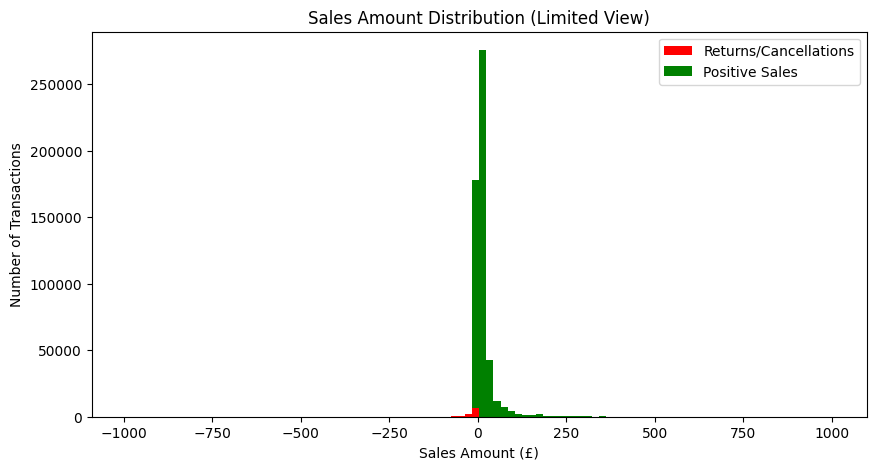

In [21]:
# Limit extreme outliers for better visualization
sales_limited = df_clean[df_clean['SalesAmount'].between(-1000, 1000)]

# Separate negative and positive sales
positive_sales = sales_limited[sales_limited['SalesAmount'] >= 0]['SalesAmount']
negative_sales = sales_limited[sales_limited['SalesAmount'] < 0]['SalesAmount']

plt.figure(figsize=(10,5))
plt.hist([negative_sales, positive_sales], bins=100, stacked=True, 
         color=['red', 'green'], label=['Returns/Cancellations', 'Positive Sales'])
plt.title('Sales Amount Distribution (Limited View)')
plt.xlabel('Sales Amount (£)')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()


The histogram shows the distribution of transaction amounts, including returns (negative values). Most transactions are small, but returns and wholesale orders create extreme values, which may require careful consideration in analysis.


In [22]:
# SALES DISTRIBUTION AND OUTLIERS

# summary statistics
sales_stats = df_clean['SalesAmount'].agg(['sum', 'mean', 'median', 'std'])
mean_median_diff = sales_stats['mean'] - sales_stats['median']

print(f"Total Sales: £{sales_stats['sum']:,.2f}")
print(f"Average: £{sales_stats['mean']:,.2f}, Median: £{sales_stats['median']:,.2f}, Std: £{sales_stats['std']:,.2f}")
print(f"Mean vs Median difference: £{mean_median_diff:,.2f}")

# extreme transactions
top_sales = df_clean.nlargest(5, 'SalesAmount')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice','SalesAmount']]
bottom_sales = df_clean.nsmallest(5, 'SalesAmount')[['InvoiceNo','StockCode','Description','Quantity','UnitPrice','SalesAmount']]

print("\nTop 5 Largest Sales:")
display(top_sales)

print("\nTop 5 Returns/Cancellations:")
display(bottom_sales)

# key invoice info for extremes
extreme_invoices = pd.concat([top_sales['InvoiceNo'], bottom_sales['InvoiceNo']]).unique()
for invoice in extreme_invoices:
    invoice_data = df_clean[df_clean['InvoiceNo'] == invoice]
    print(f"Invoice {invoice}: {len(invoice_data)} items, Total = £{invoice_data['SalesAmount'].sum():,.2f}, CustomerID = {invoice_data['CustomerID'].iloc[0]}")


Total Sales: £9,726,006.95
Average: £18.17, Median: £9.90, Std: £381.17
Mean vs Median difference: £8.27

Top 5 Largest Sales:


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,SalesAmount
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,649.50,38970.00
15017,537632,AMAZONFEE,AMAZON FEE,1,13541.33,13541.33
299982,A563185,B,Adjust bad debt,1,11062.06,11062.06



Top 5 Returns/Cancellations:


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,SalesAmount
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2.08,-168469.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,-77183.60
222681,C556445,M,Manual,-1,38970.00,-38970.00
524602,C580605,AMAZONFEE,AMAZON FEE,-1,17836.46,-17836.46
43702,C540117,AMAZONFEE,AMAZON FEE,-1,16888.02,-16888.02


Invoice 581483: 1 items, Total = £168,469.60, CustomerID = 16446.0
Invoice 541431: 1 items, Total = £77,183.60, CustomerID = 12346.0
Invoice 556444: 1 items, Total = £38,970.00, CustomerID = 15098.0
Invoice 537632: 1 items, Total = £13,541.33, CustomerID = Unknown
Invoice A563185: 1 items, Total = £11,062.06, CustomerID = Unknown
Invoice C581484: 1 items, Total = £-168,469.60, CustomerID = 16446.0
Invoice C541433: 1 items, Total = £-77,183.60, CustomerID = 12346.0
Invoice C556445: 1 items, Total = £-38,970.00, CustomerID = 15098.0
Invoice C580605: 1 items, Total = £-17,836.46, CustomerID = Unknown
Invoice C540117: 1 items, Total = £-16,888.02, CustomerID = Unknown


Total sales are ~£9.73M with an average transaction of £18.17. The large gap between mean and median shows extreme values, including high-value orders and returns. There are 9,253 negative transactions (returns), totaling £916K, which are legitimate business activities.


In [23]:
#  outlier & extreme transaction analysis

# top 10 largest sales
top_sales = df_clean.nlargest(10, 'SalesAmount')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'SalesAmount']]

#top 10 returns/cancellations
bottom_sales = df_clean.nsmallest(10, 'SalesAmount')[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'SalesAmount']]
display(top_sales)
display(bottom_sales)

#invoices involved in extreme transactions
extreme_invoices = pd.concat([top_sales['InvoiceNo'], bottom_sales['InvoiceNo']]).unique()
for invoice in extreme_invoices:
    invoice_data = df_clean[df_clean['InvoiceNo'] == invoice]
    total_value = invoice_data['SalesAmount'].sum()
    num_items = len(invoice_data)
    customer = invoice_data['CustomerID'].iloc[0]
    print(f"Invoice {invoice}: {num_items} items, Total = £{total_value:,.2f}, CustomerID = {customer}")


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,SalesAmount
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2.08,168469.60
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,77183.60
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,649.50,38970.00
15017,537632,AMAZONFEE,AMAZON FEE,1,13541.33,13541.33
299982,A563185,B,Adjust bad debt,1,11062.06,11062.06
173382,551697,POST,POSTAGE,1,8142.75,8142.75
348325,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,5.06,7144.72
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2.10,6539.40
160546,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2.10,6539.40
421601,573003,23084,RABBIT NIGHT LIGHT,2400,2.08,4992.00


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,SalesAmount
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2.08,-168469.60
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1.04,-77183.60
222681,C556445,M,Manual,-1,38970.00,-38970.00
524602,C580605,AMAZONFEE,AMAZON FEE,-1,17836.46,-17836.46
43702,C540117,AMAZONFEE,AMAZON FEE,-1,16888.02,-16888.02
43703,C540118,AMAZONFEE,AMAZON FEE,-1,16453.71,-16453.71
15016,C537630,AMAZONFEE,AMAZON FEE,-1,13541.33,-13541.33
16356,C537651,AMAZONFEE,AMAZON FEE,-1,13541.33,-13541.33
16232,C537644,AMAZONFEE,AMAZON FEE,-1,13474.79,-13474.79
524601,C580604,AMAZONFEE,AMAZON FEE,-1,11586.50,-11586.50


Invoice 581483: 1 items, Total = £168,469.60, CustomerID = 16446.0
Invoice 541431: 1 items, Total = £77,183.60, CustomerID = 12346.0
Invoice 556444: 1 items, Total = £38,970.00, CustomerID = 15098.0
Invoice 537632: 1 items, Total = £13,541.33, CustomerID = Unknown
Invoice A563185: 1 items, Total = £11,062.06, CustomerID = Unknown
Invoice 551697: 1 items, Total = £8,142.75, CustomerID = 16029.0
Invoice 567423: 12 items, Total = £31,698.16, CustomerID = 17450.0
Invoice 540815: 3 items, Total = £15,160.90, CustomerID = 15749.0
Invoice 550461: 5 items, Total = £21,535.90, CustomerID = 15749.0
Invoice 573003: 1 items, Total = £4,992.00, CustomerID = 14646.0
Invoice C581484: 1 items, Total = £-168,469.60, CustomerID = 16446.0
Invoice C541433: 1 items, Total = £-77,183.60, CustomerID = 12346.0
Invoice C556445: 1 items, Total = £-38,970.00, CustomerID = 15098.0
Invoice C580605: 1 items, Total = £-17,836.46, CustomerID = Unknown
Invoice C540117: 1 items, Total = £-16,888.02, CustomerID = Unknow

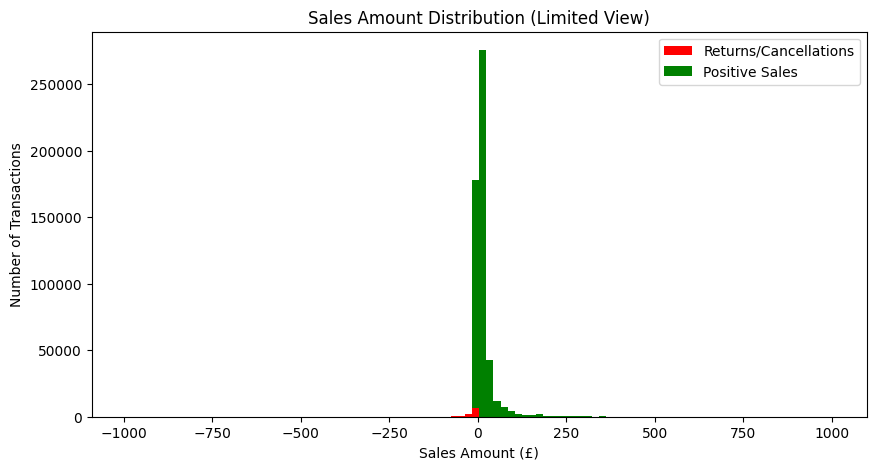

In [24]:
#visualize sales distribution with returns 
# Separate positive and negative sales
positive_sales = sales_limited[sales_limited['SalesAmount'] >= 0]['SalesAmount']
negative_sales = sales_limited[sales_limited['SalesAmount'] < 0]['SalesAmount']

plt.figure(figsize=(10,5))
plt.hist([negative_sales, positive_sales], bins=100, stacked=True, 
         color=['red', 'green'], label=['Returns/Cancellations', 'Positive Sales'])
plt.title('Sales Amount Distribution (Limited View)')
plt.xlabel('Sales Amount (£)')
plt.ylabel('Number of Transactions')
plt.legend()
plt.show()


The histogram shows the distribution of transaction amounts, with positive sales in green and returns/cancellations in red. Most transactions are small, but some extreme sales and returns reflect legitimate bulk orders, adjustments, or fees. These outliers explain why the mean transaction value is much higher than the median.

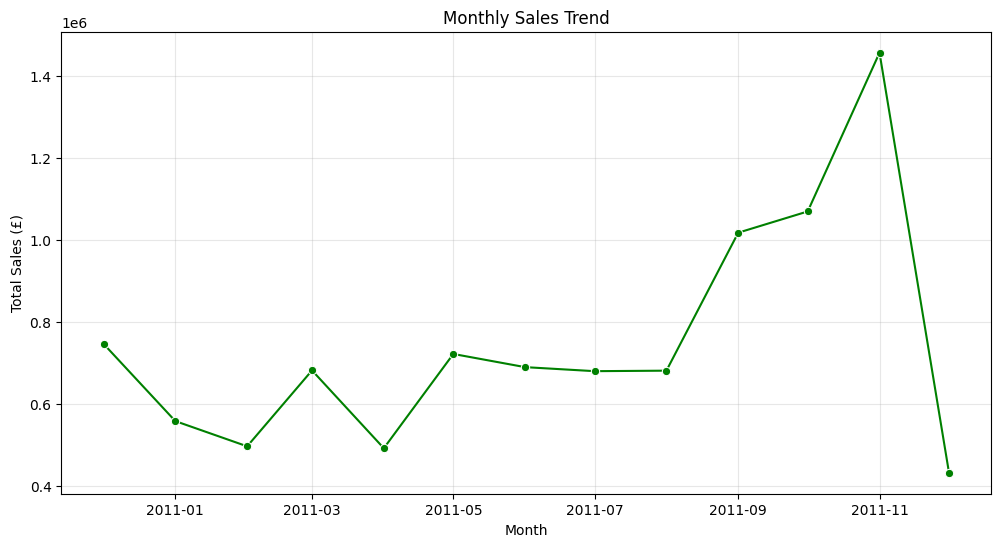

In [25]:
## Trends Analysis over time 

# aggregate sales by month
monthly_sales = df_clean.groupby(df_clean['InvoiceDate'].dt.to_period('M'))['SalesAmount'].sum().reset_index()
monthly_sales['InvoiceDate'] = monthly_sales['InvoiceDate'].dt.to_timestamp()

# plot monthly sales trend
plt.figure(figsize=(12,6))
sns.lineplot(data=monthly_sales, x='InvoiceDate', y='SalesAmount', marker='o', color='green')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.grid(True, alpha=0.3)
plt.show()

Monthly sales show clear trends over the year, with some peak periods indicating high demand. The line plot helps identify seasonality and potential periods for inventory and marketing focus.


Top 10 Products by Sales Amount:


Description
DOTCOM POSTAGE                        206245.48
REGENCY CAKESTAND 3 TIER              164459.49
WHITE HANGING HEART T-LIGHT HOLDER     99612.42
PARTY BUNTING                          98243.88
JUMBO BAG RED RETROSPOT                92175.79
RABBIT NIGHT LIGHT                     66661.63
POSTAGE                                66230.64
PAPER CHAIN KIT 50'S CHRISTMAS         63715.24
ASSORTED COLOUR BIRD ORNAMENT          58792.42
CHILLI LIGHTS                          53746.66
Name: SalesAmount, dtype: float64

Top 10 Products by Quantity Sold:


Description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     53751
JUMBO BAG RED RETROSPOT               47260
POPCORN HOLDER                        36322
ASSORTED COLOUR BIRD ORNAMENT         36282
PACK OF 72 RETROSPOT CAKE CASES       36016
WHITE HANGING HEART T-LIGHT HOLDER    35298
RABBIT NIGHT LIGHT                    30631
MINI PAINT SET VINTAGE                26437
PACK OF 12 LONDON TISSUES             26299
PACK OF 60 PINK PAISLEY CAKE CASES    24719
Name: Quantity, dtype: int64

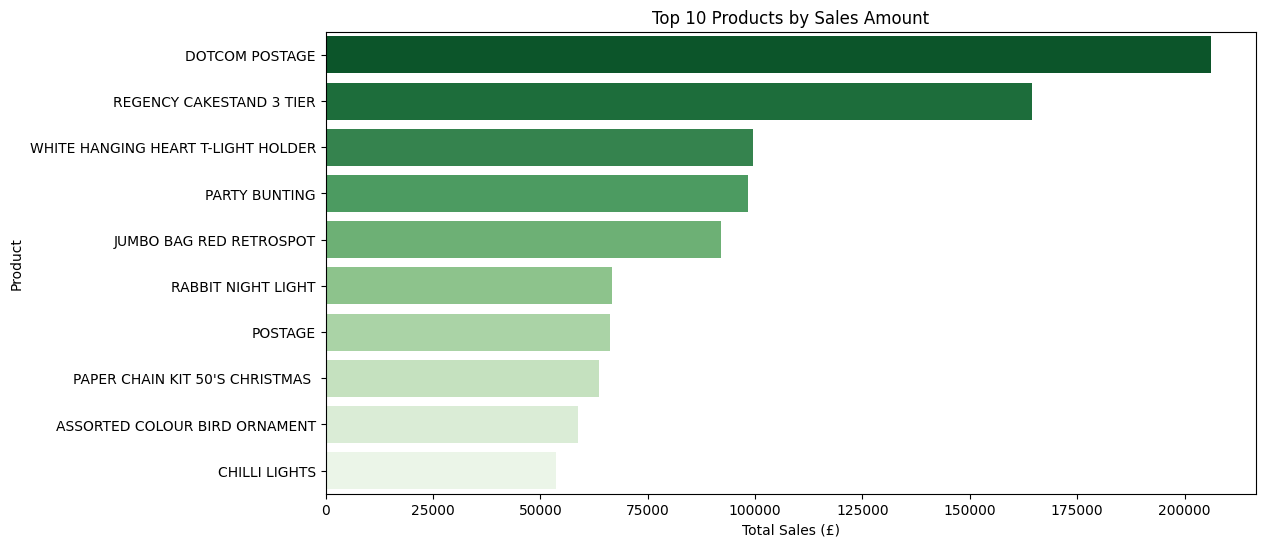

In [26]:
## Product and Category analysis

# top 10 products by total sales
top_products_sales = df_clean.groupby('Description')['SalesAmount'].sum().sort_values(ascending=False).head(10)
print("Top 10 Products by Sales Amount:")
display(top_products_sales)

# top 10 products by quantity sold
top_products_qty = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print("Top 10 Products by Quantity Sold:")
display(top_products_qty)

# visualize top 10 products by sales
plt.figure(figsize=(12,6))
sns.barplot(x=top_products_sales.values, y=top_products_sales.index, palette='Greens_r')
plt.title('Top 10 Products by Sales Amount')
plt.xlabel('Total Sales (£)')
plt.ylabel('Product')
plt.show()


The analysis identifies the top-selling products by revenue and quantity. Some items generate high sales despite lower quantities, while others sell in large quantities but with lower total revenue. This helps prioritize inventory and marketing strategies.

In [27]:
#customer analysis
# define snapshot date for recency calculation
snapshot_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

# calculate RFM metrics for each customer
rfm = df_clean[df_clean['CustomerID'] != 'Unknown'].groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                   # Frequency
    'SalesAmount': 'sum'                                      # Monetary
}).reset_index()

rfm.rename(columns={'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'SalesAmount':'Monetary'}, inplace=True)

# quick overview
print("RFM Metrics (sample):")
display(rfm.head())

RFM Metrics (sample):


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,0.00
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


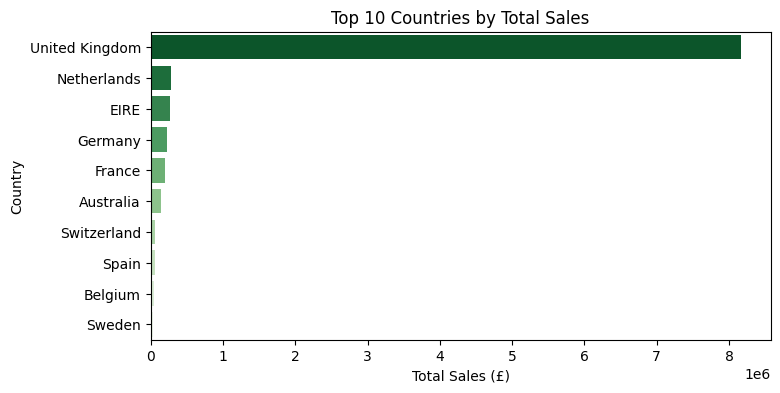

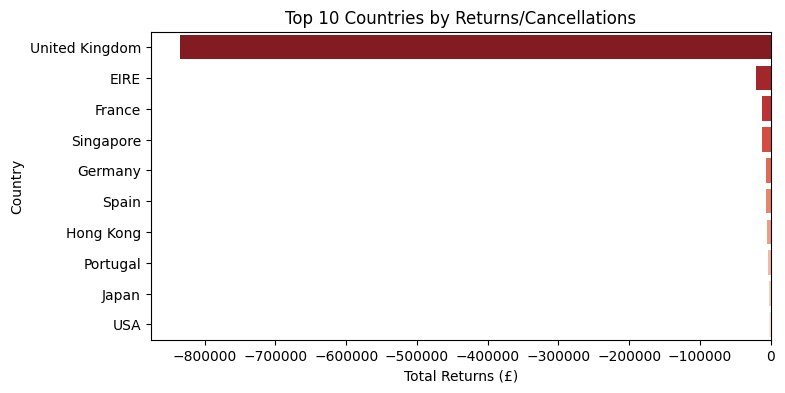

In [28]:
#geographical analysis 
# aggregate total sales by country
country_sales = df_clean.groupby('Country')['SalesAmount'].sum().sort_values(ascending=False).reset_index()

# aggregate returns by country
country_returns = df_clean[df_clean['SalesAmount'] < 0].groupby('Country')['SalesAmount'].sum().sort_values().reset_index()

# top 10 countries by sales
plt.figure(figsize=(8,4))
sns.barplot(x='SalesAmount', y='Country', data=country_sales.head(10), palette='Greens_r')
plt.title('Top 10 Countries by Total Sales')
plt.xlabel('Total Sales (£)')
plt.ylabel('Country')
plt.show()

# top 10 countries by returns
plt.figure(figsize=(8,4))
sns.barplot(x='SalesAmount', y='Country', data=country_returns.head(10), palette='Reds_r')
plt.title('Top 10 Countries by Returns/Cancellations')
plt.xlabel('Total Returns (£)')
plt.ylabel('Country')
plt.show()


Geographical analysis shows which countries generate the most sales and which have the highest returns. This helps identify top markets for focus and potential regions where returns or cancellations are significant, guiding regional marketing or operational strategies.


Correlation Matrix:


,Quantity,UnitPrice,SalesAmount
Quantity,1.000000,-0.001254,0.888196
UnitPrice,-0.001254,1.000000,-0.162050
SalesAmount,0.888196,-0.162050,1.000000


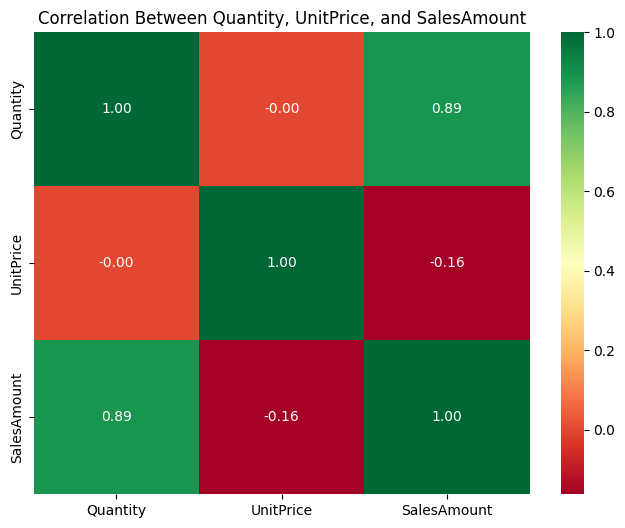

In [29]:
#correlation Analysis 
#relevant columns
corr_data = df_clean[['Quantity', 'UnitPrice', 'SalesAmount']]

# compute correlation matrix
corr_matrix = corr_data.corr()

# display correlation matrix
print("Correlation Matrix:")
display(corr_matrix)

# visualize correlation matrix
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Correlation Between Quantity, UnitPrice, and SalesAmount')
plt.show()


SalesAmount is strongly influenced by Quantity and UnitPrice, as shown in the correlation matrix and scatter plots. Larger quantities and higher unit prices naturally increase total sales. This analysis also helps identify patterns in returns or bulk purchases relative to item price and quantity.


## Data Mining Modeling Methods, Validation, and Performance Metrics

Model: Logistic Regression
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    157776
           1       1.00      1.00      1.00      2781

    accuracy                           1.00    160557
   macro avg       1.00      1.00      1.00    160557
weighted avg       1.00      1.00      1.00    160557

ROC-AUC: 1.0


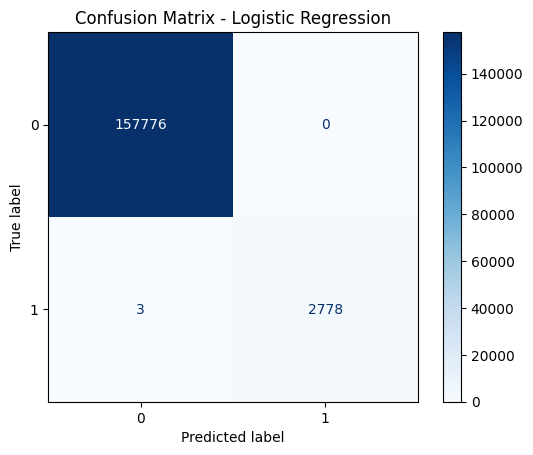

Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    157776
           1       1.00      1.00      1.00      2781

    accuracy                           1.00    160557
   macro avg       1.00      1.00      1.00    160557
weighted avg       1.00      1.00      1.00    160557

ROC-AUC: 1.0


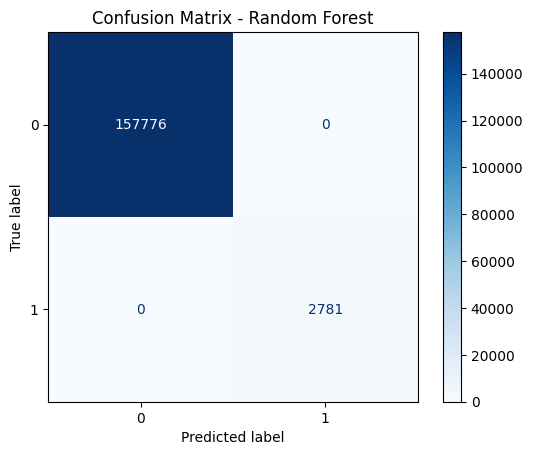

In [36]:
df_clean['IsReturn'] = (df_clean['SalesAmount'] < 0).astype(int)

X = df_clean[['Quantity', 'UnitPrice', 'SalesAmount']]
y = df_clean['IsReturn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    print("="*60)
    print(f"Model: {name}")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    # Performance metrics
    print(classification_report(y_test, preds))
    print("ROC-AUC:", roc_auc_score(y_test, probs))

    # Confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds))
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

Both the Logistic Regression and Random Forest models accurately predicted whether a transaction was a return or a successful sale. Each achieved perfect performance metrics—accuracy = 1.00, precision = 1.00, recall = 1.00, F1-score = 1.00, and ROC-AUC = 1.00—with no misclassifications shown in the confusion matrices.

These results indicate that the models perfectly separated return transactions from normal sales, largely because SalesAmount directly captures that distinction (i.e., negative values represent returns). While this explains the perfect prediction, it also suggests the model is learning an explicit rule already present in the data rather than discovering new behavioral patterns.

From a business perspective, the findings confirm that transaction value signs and quantities are reliable indicators of returns. This modeling exercise demonstrates how classification methods and evaluation metrics can be used to validate data relationships, supporting decision-making in e-commerce analytics.